# Imports and spark config

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.appName("spark").getOrCreate()
spark

In [3]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 5)

# Data preparation

In [4]:
df = spark.read.csv(r"c:\Users\Vincenzo\PROJECTS\DDAM_data\brewery\brewery_data_complete_extended.csv", header=True, inferSchema=True)
type(df)

pyspark.sql.dataframe.DataFrame

In [5]:
df.printSchema()
rows = df.count()
cols = len(df.columns)

print(f'Dimension of the Dataframe is: {(rows,cols)}')
df.show(5)

root
 |-- Batch_ID: integer (nullable = true)
 |-- Brew_Date: timestamp (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)

Dimension of the Dataframe is: (10000000, 20)
+--------+-------------------+----------+--

In [6]:
sample = df.sample(fraction=0.1, seed=42).drop("Batch_ID")

In [7]:
summary_stats = sample.toPandas().describe()

rounded_describe = np.round(summary_stats, 2)

In [8]:
rounded_describe

,Brew_Date,Fermentation_Time,Temperature,pH_Level,Gravity,Alcohol_Content,Bitterness,Color,Volume_Produced,Total_Sales,Quality_Score,Brewhouse_Efficiency,Loss_During_Brewing,Loss_During_Fermentation,Loss_During_Bottling_Kegging
count,1001020,1001020.00,1001020.00,1001020.00,1001020.00,1001020.00,1001020.00,1001020.00,1001020.00,1001020.00,1001020.00,1001020.00,1001020.00,1001020.00,1001020.00
mean,2022-01-01 09:16:51.822855168,14.50,20.00,5.00,1.05,5.25,39.49,12.01,2750.00,10508.42,8.00,80.01,3.00,3.00,3.00
min,2020-01-01 00:01:51,10.00,15.00,4.50,1.03,4.50,20.00,5.00,500.00,1000.03,6.00,70.00,1.00,1.00,1.00
25%,2021-01-01 14:31:35.249999872,12.00,17.50,4.75,1.04,4.87,29.00,8.00,1627.00,5757.84,7.00,75.01,2.00,2.00,2.00
50%,2022-01-02 03:18:50,14.00,20.00,5.00,1.05,5.25,39.00,12.00,2749.00,10515.93,8.00,80.01,3.00,3.00,3.00
75%,2023-01-01 13:05:02,17.00,22.50,5.25,1.07,5.62,49.00,16.00,3873.00,15262.87,9.00,85.03,4.00,4.00,4.00
max,2023-12-31 23:59:54,19.00,25.00,5.50,1.08,6.00,59.00,19.00,4999.00,19999.98,10.00,90.00,5.00,5.00,5.00
std,NaN,2.87,2.89,0.29,0.01,0.43,11.54,4.32,1298.07,5484.88,1.16,5.78,1.16,1.15,1.15


In [9]:
from pyspark.sql.functions import split, col

# Split the ratio_column into three parts based on the colon delimiter
split_col = split(col("Ingredient_Ratio"), ":")

# Create three separate columns for water, grains, and hops
sample = sample.withColumn("water", split_col.getItem(0).cast("float"))
sample = sample.withColumn("grains", split_col.getItem(1).cast("float"))
sample = sample.withColumn("hops", split_col.getItem(2).cast("float"))
sample = sample.drop("Ingredient_Ratio")
# Now you have three separate columns for water, grains, and hops with their respective values

In [10]:
# Define a new column with the USD per liter ratio
sample = sample.withColumn("USD_per_Liter", F.col("Total_Sales") / F.col("Volume_Produced"))

In [11]:
from pyspark.sql.types import StringType

# Identify numerical and non-numerical columns
numerical_cols = [col_name for col_name, data_type in sample.dtypes if data_type != 'string']
categorical_cols = [col_name for col_name, data_type in sample.dtypes if data_type == 'string']

print(f'Numerical columns: {numerical_cols}')
print(f'Categorical columns: {categorical_cols}')

Numerical columns: ['Brew_Date', 'Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity', 'Alcohol_Content', 'Bitterness', 'Color', 'Volume_Produced', 'Total_Sales', 'Quality_Score', 'Brewhouse_Efficiency', 'Loss_During_Brewing', 'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging', 'water', 'grains', 'hops', 'USD_per_Liter']
Categorical columns: ['Beer_Style', 'SKU', 'Location']


In [12]:
distinct_num_counts = {}

for col in numerical_cols:
    distinct_count = sample.select(col).distinct().count()
    distinct_num_counts[col] = distinct_count

    print(f"- {col} - {distinct_count} distinct values")

print(distinct_num_counts)

- Brew_Date - 997008 distinct values
- Fermentation_Time - 10 distinct values
- Temperature - 1001020 distinct values
- pH_Level - 1001020 distinct values
- Gravity - 1001020 distinct values
- Alcohol_Content - 1001020 distinct values
- Bitterness - 40 distinct values
- Color - 15 distinct values
- Volume_Produced - 4500 distinct values
- Total_Sales - 1001020 distinct values
- Quality_Score - 1001020 distinct values
- Brewhouse_Efficiency - 1001020 distinct values
- Loss_During_Brewing - 1001020 distinct values
- Loss_During_Fermentation - 1001020 distinct values
- Loss_During_Bottling_Kegging - 1001020 distinct values
- water - 1 distinct values
- grains - 31 distinct values
- hops - 21 distinct values
- USD_per_Liter - 1001020 distinct values
{'Brew_Date': 997008, 'Fermentation_Time': 10, 'Temperature': 1001020, 'pH_Level': 1001020, 'Gravity': 1001020, 'Alcohol_Content': 1001020, 'Bitterness': 40, 'Color': 15, 'Volume_Produced': 4500, 'Total_Sales': 1001020, 'Quality_Score': 1001020

In [13]:
# for col in numerical_cols:
#     print(" - {} ".format(col) + " - " + str(sample.select(col).distinct().count()) + " distinct values")

In [14]:
# for col in categorical_cols:
#     print(" - {} ".format(col) + " - " + str(sample.select(col).distinct().count()) + " distinct values")

In [15]:
distinct_cat_counts = {}

for col in categorical_cols:
    distinct_count = sample.select(col).distinct().count()
    distinct_cat_counts[col] = distinct_count

    print(f"- {col} - {distinct_count} distinct values")

print(distinct_cat_counts)

- Beer_Style - 8 distinct values
- SKU - 4 distinct values
- Location - 10 distinct values
{'Beer_Style': 8, 'SKU': 4, 'Location': 10}


# Data Exploration

In [16]:
# small_num_distinct = [col for col in numerical_cols if sample.select(col).distinct().count() <= 10]
# print(small_num_distinct)

numerical_cols.remove("water")
small_num_distinct = ['Fermentation_Time']

In [17]:
histogram = []
histogram += [col for col in numerical_cols if col not in small_num_distinct or col != "water"]

print(histogram)

['Brew_Date', 'Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity', 'Alcohol_Content', 'Bitterness', 'Color', 'Volume_Produced', 'Total_Sales', 'Quality_Score', 'Brewhouse_Efficiency', 'Loss_During_Brewing', 'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging', 'grains', 'hops', 'USD_per_Liter']


In [18]:
# # Step 2: Plot histograms for numerical columns
# for col in numerical_cols:
#     plt.figure(figsize=(4, 3))
#     sns.histplot(data=sample.select(col).toPandas(), x=col, kde=True)
#     plt.title(f'Histogram for {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.show()

In [19]:
# Step 3: Plot bar plots for categorical columns
print(categorical_cols + small_num_distinct)

['Beer_Style', 'SKU', 'Location', 'Fermentation_Time']


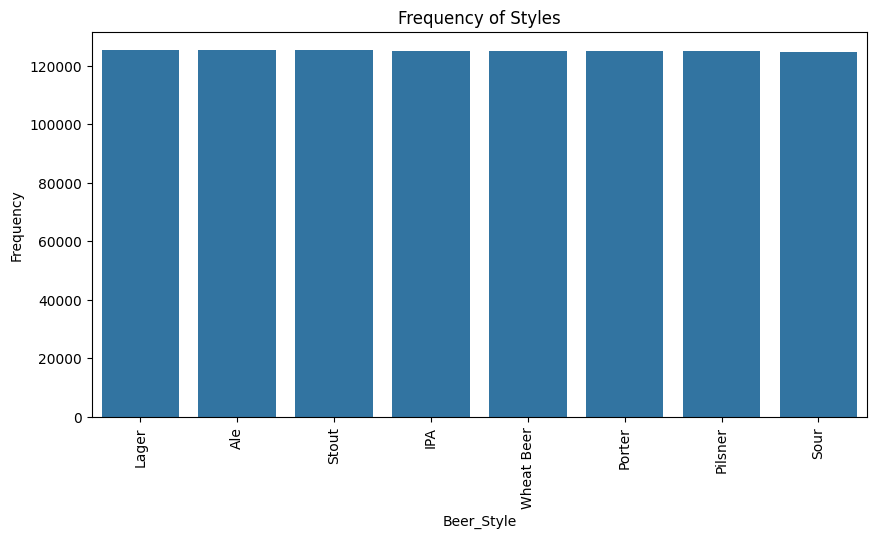

In [20]:
style_frequency = sample.groupBy("Beer_Style").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=style_frequency, x="Beer_Style", y="count", order=style_frequency.sort_values('count', ascending=False)["Beer_Style"])
plt.title('Frequency of Styles')
plt.xlabel('Beer_Style')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

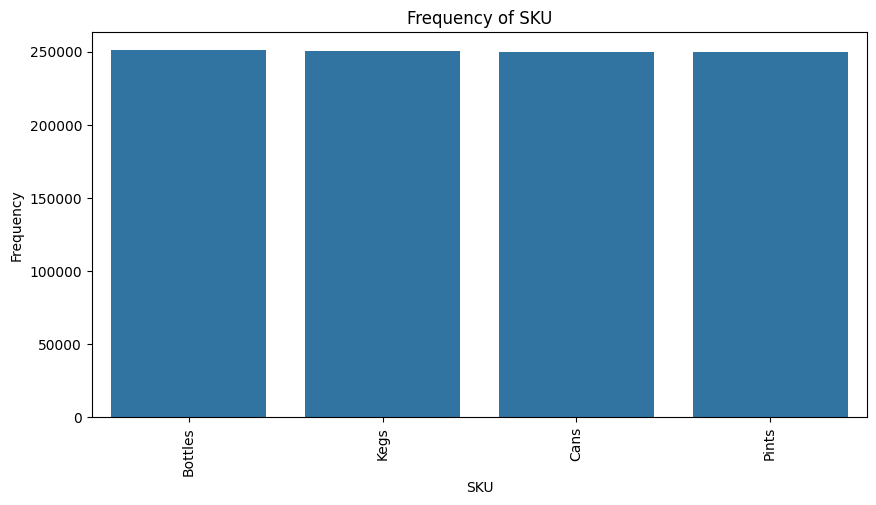

In [21]:
sku_frequency = sample.groupBy("SKU").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=sku_frequency, x="SKU", y="count", order=(sku_frequency.sort_values(by="count", ascending=False))['SKU'])
plt.title('Frequency of SKU')
plt.xlabel('SKU')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

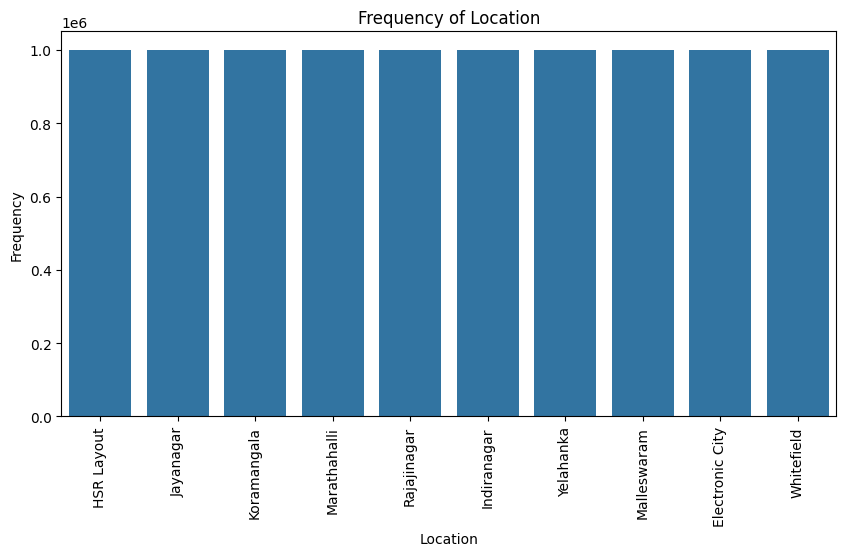

In [22]:
location_frequency = df.groupBy("Location").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=location_frequency, x="Location", y="count", order=(location_frequency.sort_values(by="count", ascending=False))['Location'])
plt.title('Frequency of Location')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

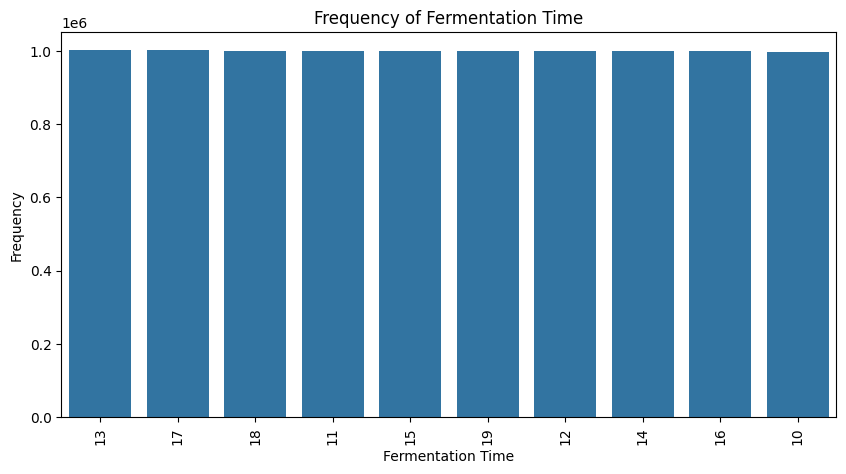

In [23]:
fermentation_frequency = df.groupBy("Fermentation_Time").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=fermentation_frequency, x="Fermentation_Time", y="count", order=(fermentation_frequency.sort_values(by="count", ascending=False))['Fermentation_Time'])
plt.title('Frequency of Fermentation Time')
plt.xlabel('Fermentation Time')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


# Closing statements

In [25]:
spark.stop()